<h2> Importing all necessary Libraries </h2>

In [1]:
# Standard imports
import os
import pandas as pd
import numpy as np                                                                  
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from skimage import io

import seaborn as sns
from tqdm import trange, tqdm
from colorama import Fore
from glob import glob
import json
from pprint import pprint
import time
import cv2
from enum import Enum
from IPython.display import display, HTML, Image, Video
# from pandas_profiling import ProfileReport
import random
import inspect
from uuid import uuid4

# For Data preparation
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *


In [2]:
#Loading the data

data_directory = 'data'  # Change this to your dataset directory

class Config:
    IMG_SIZE = 512
    DATA_PATH = 'data'
    COLS = [
        "image_id",
        "path",
        "bbox",
        "label",
        "width",
        "height"
    ]
    ORIGINAL_IMG_SHAPE = (512, 512)
    CONFIG_FILENAME = "weed_data"
    OUTPUT_PATH = "yolov5/output"
    EPOCHS = 20
    BATCH_SIZE = 8

In [4]:
def process_data(data_df: "pandas dataFrame", image_id_col: str, bbox_col: str, label_col: str, path_col: str, config_filename="data", test_size=0.1):
    """
    Helper function to build dataset for yolo training
        > Yolo expects the data in the form: (label, x_center, y_center, Width,  Height)
        > return df_train, df_val
    """
    os.system("git clone https://github.com/ultralytics/yolov5.git")
    OUTPUT_FOLDER_NAME = Config.OUTPUT_PATH.split("/")[-1]
    if not os.path.exists(Config.OUTPUT_PATH):
        os.system(
            f'''
                cd yolov5
                mkdir {OUTPUT_FOLDER_NAME} 
                cd {OUTPUT_FOLDER_NAME}
                mkdir images
                mkdir labels
                cd images
                mkdir train
                mkdir validation
                cd ..
                cd labels
                mkdir train
                mkdir validation
                cd ../../
                tree {OUTPUT_FOLDER_NAME}
                cd ../
            ''')

    # For converting string form of list to original form
    if isinstance(data_df.bbox.values[0], str):
        data_df.bbox = data_df.bbox.apply(ast.literal_eval)

    # Encoding all labels
    mapper = {k: d for d, k in enumerate(sorted(data_df[label_col].unique()))}
    data_df[label_col] = data_df[label_col].apply(lambda x: int(mapper[x]))
    
    # Grouping the bounding boxes and paths wrt label_col 
    grpBy_obj = data_df.groupby(by=[image_id_col, path_col])
    bbox_df = grpBy_obj[bbox_col].apply(list).reset_index(name=bbox_col)
    label_df = grpBy_obj[label_col].apply(list).reset_index(name=label_col)
    
    label_df[label_col] = label_df[label_col].apply(lambda x: x  if len(set(x)) > 1 else x[0])
    
    data_df = bbox_df.merge(label_df, on = [image_id_col, path_col], how = "inner")
    
    # Dividing the data into train and val set
    df_train, df_val = train_test_split(data_df, test_size = test_size, shuffle = True, random_state = 42) 
    df_train = df_train.reset_index(drop = 1)
    df_val = df_val.reset_index(drop = 1)

    print(f"[INFO] Train_SHAPE : {df_train.shape}, VAL_SHAPE: {df_val.shape}")

    data_dict = {"train": df_train, "validation": df_val}
    for data_type, data in data_dict.items():
        for idx in trange(len(data), desc=f"Processing {data_type}...", bar_format="{l_bar}%s{bar:50}%s{r_bar}" % (Fore.CYAN, Fore.RESET), position=0, leave=True):
            row = data.loc[idx]
            image_name = row[image_id_col]
            bounding_boxes = row[bbox_col]
            labels = row[label_col]
            path = row[path_col]
            yolo_data = []
            for bbox in bounding_boxes:
                x = bbox[0]
                y = bbox[1]
                w = bbox[2]
                h = bbox[3]

                x_center = x + w/2
                y_center = y + h/2
                
                # Normalizing the center co-ordiantes, w and h
                W, H = Config.ORIGINAL_IMG_SHAPE
                x_center /= W; w /= W
                y_center /= H; h /= H
                
                if isinstance(labels, list):
                    for label in labels:
                        yolo_data.append([label, x_center, y_center, w, h])
                else:
                    yolo_data.append([labels, x_center, y_center, w, h])

            yolo_data = np.array(yolo_data)
            np.savetxt(
                f"{Config.OUTPUT_PATH}/labels/{data_type}/{image_name}.txt",
                yolo_data,
                fmt=["%d", "%f", "%f", "%f", "%f"]
            )
            
            # Copying the image to the output folder
            os.system(
                f"""
                cp {path} {Config.OUTPUT_PATH}/images/{data_type}/{path.split("/")[-1]}
                """
            )
    
    # Creating the data yaml file
    with open(f"yolov5/{config_filename}.yaml", "w+") as file_:
        file_.write(
            f"""
            
            train: {OUTPUT_FOLDER_NAME}/images/train
            val: {OUTPUT_FOLDER_NAME}/images/validation
            nc: {len(mapper)}
            names: {list(mapper.keys())}
            
            """
        )
    file_.close()
    print("[INFO] Done with data processing")


    
def trainYoloModel(model_name: str, config_filename: str, preTrainedWeights_path=None, showInteractive=False):
    """
    Helper function to train YOLO v5 models
    """
    mapper = {}
    for idx, model_ in enumerate(glob("yolov5/models/*yaml")):
        mapper[idx + 1] = model_
        print(f"{idx + 1} =>  {model_.split('/')[-1].split('.')[0]}")
    
    pprint(f"[DEBUG] mapper : {mapper}")
    if showInteractive:
        model = mapper[int(input(f"Select the model from the idx: "))]
    else:
        model = mapper[3] # Training yolovsmall
    shape = Config.IMG_SIZE
    bs = Config.BATCH_SIZE
    epochs = Config.EPOCHS

    os.system(
        f"""
            python yolov5/train.py --img {shape} --batch {bs} --epochs {epochs} --data yolov5/{config_filename}.yaml --cfg {model} --name {model_name} {'--weights' + preTrainedweights_path if preTrainedWeights_path is not None else ""}   
        """
    )
        
def predict(images_path:"path to the test images", weights_path: "path to the weights folder"):
    """
    Helper function to make predictions over images using Yolo
    """
    os.system(f"python yolov5/detect.py --source {images_path} --weights {weights_path}")

In [5]:
classes_mapper = {
    0: "crop",
    1: "weed"
}

images_list = list(filter(lambda x: x.split(".")[1] == "jpeg", os.listdir(Config.DATA_PATH)))
txts_list = list(filter(lambda x: x.split(".")[1] == "txt", os.listdir(Config.DATA_PATH)))

classes_mapper

{0: 'crop', 1: 'weed'}

In [6]:
counter = [0, 0, 0]
for txt_file in txts_list:
    coords = list(map(lambda x: x.replace("\n", ""), open(f"{Config.DATA_PATH}/{txt_file}", "r").readlines()))
    for coord in coords:
        label, _, _, _, _ = coord.split()
        counter[int(label)] += 1

for i in range(2):
    print(f"{classes_mapper[i]} : {counter[i]}")

crop : 1212
weed : 860


In [7]:
Config.COLS

['image_id', 'path', 'bbox', 'label', 'width', 'height']

In [8]:
df = pd.DataFrame(columns = Config.COLS)

for txt_file in txts_list:
    img_file = f"{txt_file.split('.')[0]}.jpeg"
    bboxes = list(map(lambda x: x.replace("\n", ""), open(f"{Config.DATA_PATH}/{txt_file}").readlines()))
    for bbox in bboxes:
        label, x_center, y_center, W, H = bbox.split()
        label = int(label)
        x_center, y_center, W, H = list(map(lambda x: float(x), [x_center, y_center, W, H]))
        x1 = int(512*(x_center - W/2))
        x2 = int(512*(x_center + W/2))
        y1 = int(512*(y_center - H/2))
        y2 = int(512*(y_center + H/2))
        image_id = img_file.split(".")[0]
        path = f"{Config.DATA_PATH}/{img_file}"
        bbox = [x1, y1, x2, y2]
        label = classes_mapper[label]
        width = height = Config.IMG_SIZE
        
        # Appending row to the df
        row = [image_id, path, bbox, label, width, height]
        df.loc[len(df)] = row

df

,image_id,path,bbox,label,width,height
0,agri_0_1009,data/agri_0_1009.jpeg,"[172, 119, 449, 391]",weed,512,512
1,agri_0_1017,data/agri_0_1017.jpeg,"[8, 4, 500, 390]",weed,512,512
2,agri_0_1018,data/agri_0_1018.jpeg,"[20, 84, 434, 409]",weed,512,512
3,agri_0_1020,data/agri_0_1020.jpeg,"[66, 23, 440, 336]",weed,512,512
4,agri_0_1024,data/agri_0_1024.jpeg,"[161, 76, 453, 381]",weed,512,512
...,...,...,...,...,...,...
2067,agri_0_9963,data/agri_0_9963.jpeg,"[58, 80, 455, 336]",weed,512,512
2068,agri_0_9971,data/agri_0_9971.jpeg,"[45, 132, 228, 311]",weed,512,512
2069,agri_0_9971,data/agri_0_9971.jpeg,"[52, 355, 227, 512]",weed,512,512
2070,agri_0_9971,data/agri_0_9971.jpeg,"[272, 80, 458, 310]",weed,512,512


In [9]:
df[df.image_id == "agri_0_9354"]

,image_id,path,bbox,label,width,height
1959,agri_0_9354,data/agri_0_9354.jpeg,"[63, 120, 425, 442]",weed,512,512
1960,agri_0_9354,data/agri_0_9354.jpeg,"[0, 1, 180, 148]",weed,512,512


[1002] x1, y1, x2, y2:  167 208 323 339
Label: weed


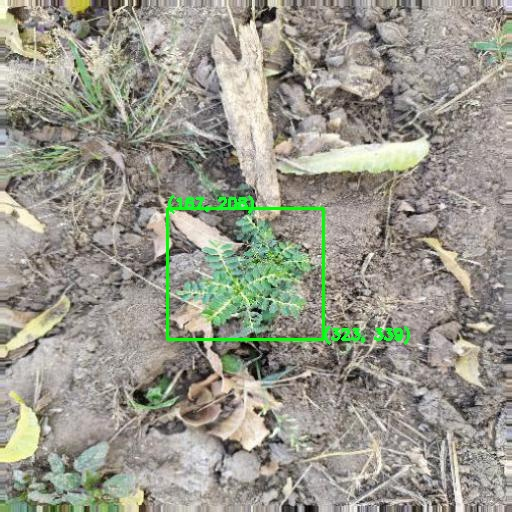

[443] x1, y1, x2, y2:  343 256 398 307
Label: crop


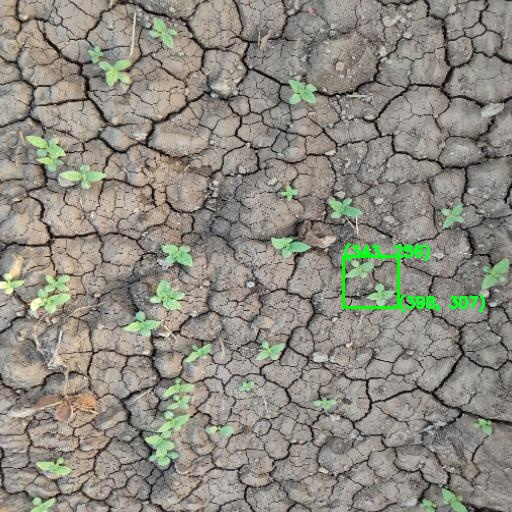

[754] x1, y1, x2, y2:  344 3 411 101
Label: weed


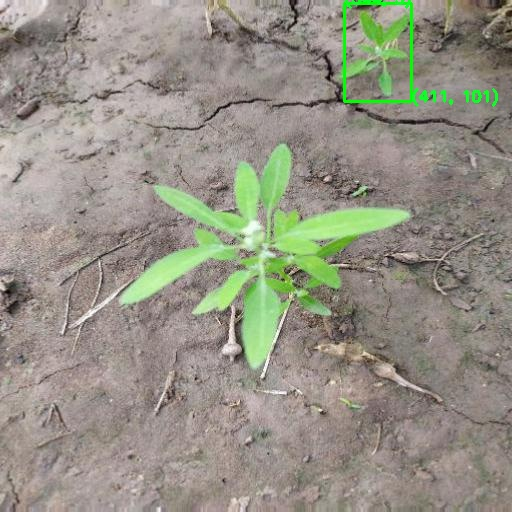

[675] x1, y1, x2, y2:  222 180 250 211
Label: crop


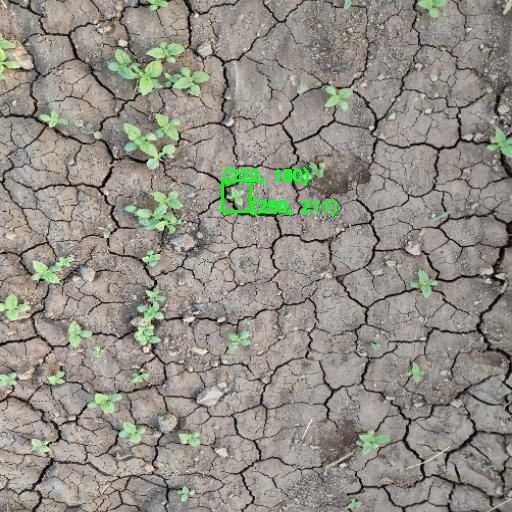

[1851] x1, y1, x2, y2:  414 257 512 426
Label: weed


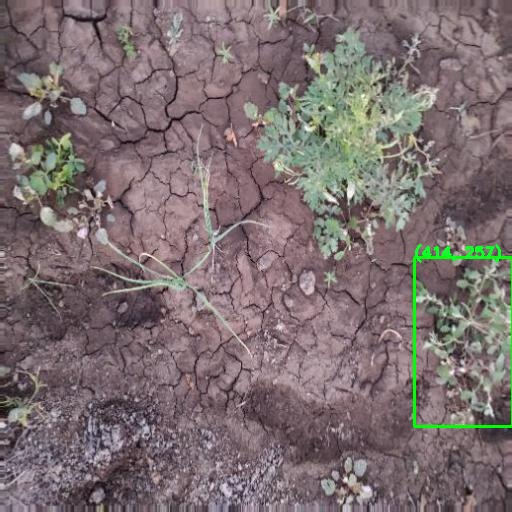

[26] x1, y1, x2, y2:  31 30 444 328
Label: crop


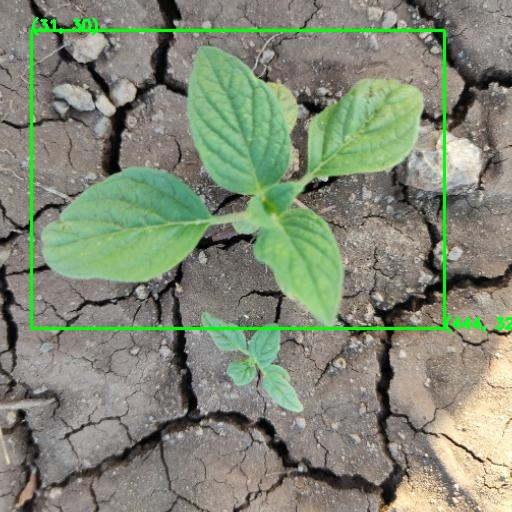

[813] x1, y1, x2, y2:  11 71 442 442
Label: weed


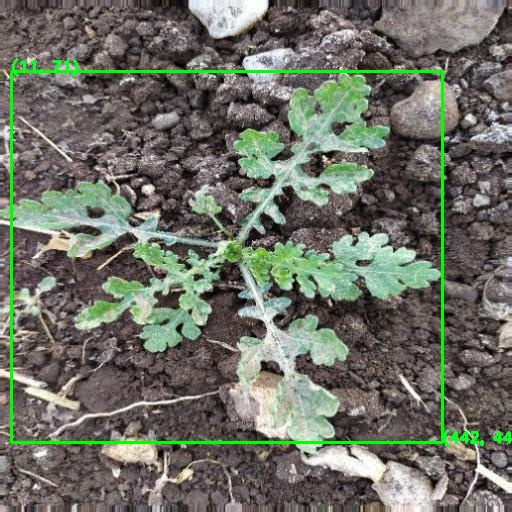

[2060] x1, y1, x2, y2:  169 122 329 282
Label: weed


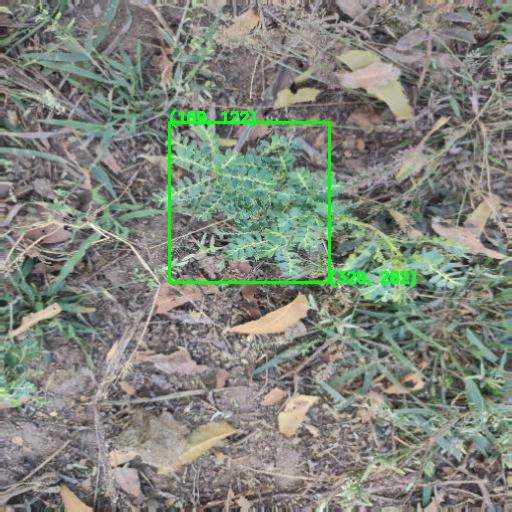

[1490] x1, y1, x2, y2:  207 198 297 308
Label: weed


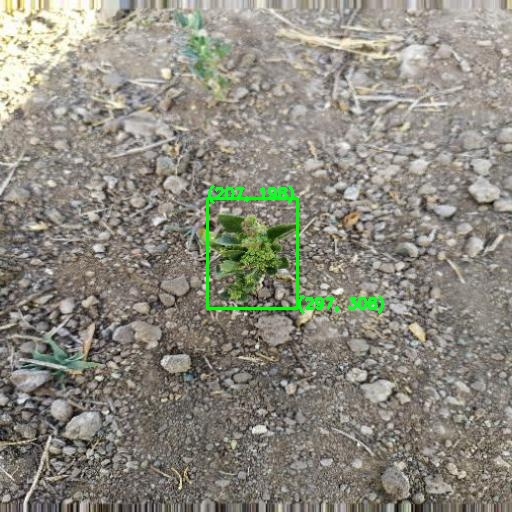

[1107] x1, y1, x2, y2:  83 31 430 415
Label: weed


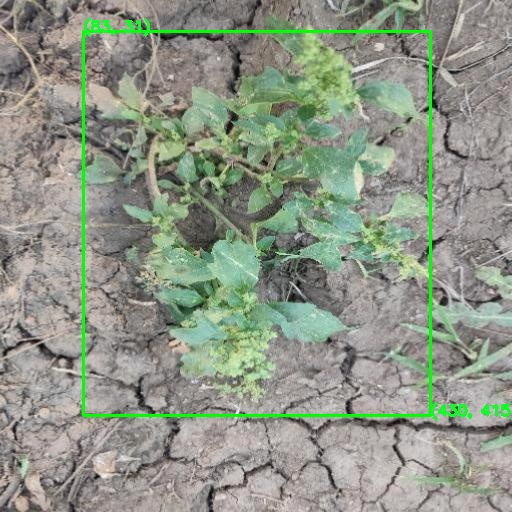

In [10]:
for idx, row in df.sample(10).iterrows():
    name = row["path"].split("/")[-1]
    image = cv2.imread(row["path"])
    x1, y1, x2, y2 = tuple(map(lambda a: int(a),row["bbox"]))
    print(f"[{idx}] x1, y1, x2, y2: ", x1, y1, x2, y2)
    print(f"Label: {row['label']}")
    image = cv2.rectangle(image,(x1,y1), (x2,y2), (0,255,0), 2)
    cv2.putText(image, f"({x1}, {y1})", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    cv2.putText(image, f"({x2}, {y2})", (x2, y2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    cv2.imwrite(f"./{name}", image)
    display(Image(filename=f"./{name}"))

In [12]:
process_data(data_df = df, 
             image_id_col = "image_id", 
             bbox_col = "bbox", 
             label_col = "label",
             path_col = "path", 
             config_filename = Config.CONFIG_FILENAME)

[INFO] Train_SHAPE : (1170, 4), VAL_SHAPE: (130, 4)


Processing validation...: 100%|██████████████████████████████████████████████████| 130/130 [00:04<00:00, 26.05it/s]

[INFO] Done with data processing


In [13]:
!echo "Lets look inside the data.yaml file"
!ls -1 "yolov5/output/images/train" | wc -l
!cat "./yolov5/weed_data.yaml"
!echo ""
!head "yolov5/output/labels/train/agri_0_8252.txt" 

"Lets look inside the data.yaml file"


'ls' is not recognized as an internal or external command,
operable program or batch file.
'cat' is not recognized as an internal or external command,
operable program or batch file.


""


'head' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
# Different Models
for idx, model_ in enumerate(glob("yolov5/models/*yaml")):
    print(f"{idx + 1} =>  {model_.split('/')[-1].split('.')[0]}, path: {model_}")

1 =>  models\yolov5l, path: yolov5/models\yolov5l.yaml
2 =>  models\yolov5m, path: yolov5/models\yolov5m.yaml
3 =>  models\yolov5n, path: yolov5/models\yolov5n.yaml
4 =>  models\yolov5s, path: yolov5/models\yolov5s.yaml
5 =>  models\yolov5x, path: yolov5/models\yolov5x.yaml


In [15]:
def trainYoloModel(
    model_name: str,
    config_filename: str,
    preTrainedWeights_path=None,
    model=None
):
    """
    Helper function to train YOLO v5 models
    """
    mapper = {}
    for idx, model_ in enumerate(glob("yolov5/models/*yaml")):
        mapper[idx + 1] = model_
        print(f"{idx + 1} =>  {model_.split('/')[-1].split('.')[0]}")
    
    pprint(f"[DEBUG] mapper : {mapper}")
    if model is None:
        model = mapper[int(input(f"Select the model from the idx: "))]
        
    shape = Config.IMG_SIZE
    bs = Config.BATCH_SIZE
    epochs = Config.EPOCHS

    os.system(
        f"""
            python yolov5/train.py --img {shape} --batch {bs} --epochs {epochs} --data yolov5/{config_filename}.yaml --cfg {model} --name {model_name} {'--weights' + preTrainedweights_path if preTrainedWeights_path is not None else ""}   
        """
    )

In [16]:
trainYoloModel(
        model_name = "weed_detection", 
        config_filename = Config.CONFIG_FILENAME, 
        preTrainedWeights_path = None,
        model = "yolov5/models/yolov5x.yaml"
    )

1 =>  models\yolov5l
2 =>  models\yolov5m
3 =>  models\yolov5n
4 =>  models\yolov5s
5 =>  models\yolov5x
("[DEBUG] mapper : {1: 'yolov5/models\\\\yolov5l.yaml', 2: "
 "'yolov5/models\\\\yolov5m.yaml', 3: 'yolov5/models\\\\yolov5n.yaml', 4: "
 "'yolov5/models\\\\yolov5s.yaml', 5: 'yolov5/models\\\\yolov5x.yaml'}")
